In [1]:
import os, re, json, textwrap, requests
from pathlib import Path
import dotenv
import pandas as pd
from IPython.display import display

In [2]:
# --- Load env vars from tests/test.env if not already in environment ---
env_file = Path('../tests/test.env')
print(env_file)
if env_file.exists():
    dotenv.load_dotenv(env_file)
    print('Loaded env file at', env_file.resolve())
else:
    print('No env file found at', env_file.resolve())
BASE_URL = os.getenv('API_BASE_URL', 'http://localhost:8002')  # docker-compose maps 8002->8000
LOGIN_EMAIL = os.getenv('TEST_LOGIN_EMAIL')
LOGIN_PASSWORD = os.getenv('TEST_LOGIN_PASSWORD')
ROUTE_ID = os.getenv('TEST_ROUTE_ID', '55f151ad-63f8-40dc-85e7-330becb51c75')
PRE_TOKEN = os.getenv('TEST_API_TOKEN')
DAY = 'monday'  # requested filter

print('Configured:')
print(' BASE_URL=', BASE_URL)
print(' EMAIL=', LOGIN_EMAIL)
print(' ROUTE_ID=', ROUTE_ID)
print(' DAY=', DAY)

../tests/test.env
Loaded env file at /home/elettra/projects/elettra-backend/tests/test.env
Configured:
 BASE_URL= http://localhost:8002
 EMAIL= test01.elettra@fart.ch
 ROUTE_ID= 55f151ad-63f8-40dc-85e7-330becb51c75
 DAY= monday


In [3]:
session = requests.Session()
token = PRE_TOKEN
if not token:
    assert LOGIN_EMAIL and LOGIN_PASSWORD, 'Missing login credentials'
    r = session.post(f'{BASE_URL}/auth/login', json={'email': LOGIN_EMAIL, 'password': LOGIN_PASSWORD})
    if r.status_code != 200:
        raise SystemExit(f'Login failed: {r.status_code} {r.text}')
    data = r.json()
    token = data.get('access_token')
    assert token, 'No access_token in response'
print('Got token (first 32 chars):', token[:32] + '...')

Got token (first 32 chars): eyJhbGciOiJIUzI1NiIsInR5cCI6IkpX...


In [4]:
headers = {'Authorization': f'Bearer {token}'}
base_endpoint = f'{BASE_URL}/api/v1/gtfs/gtfs-trips/by-route/{ROUTE_ID}'

def fetch(url):
    r = session.get(url, headers=headers, timeout=30)
    if r.status_code != 200:
        raise RuntimeError(f'GET {url} -> {r.status_code}: {r.text[:300]}')
    return r.json()

trips_all = fetch(base_endpoint)
trips_day = fetch(base_endpoint + f'?day_of_week={DAY}')
print(f'Total trips (no filter): {len(trips_all)}')
print(f'Total trips ({DAY}): {len(trips_day)}')
print('Subset OK:', set(t['id'] for t in trips_day).issubset({t['id'] for t in trips_all}))
# Show sample
sample = trips_day[:3] if trips_day else []
print('Sample filtered trips (up to 3):')
print(json.dumps(sample, indent=2)[:1000])

Total trips (no filter): 2549
Total trips (monday): 1052
Subset OK: True
Sample filtered trips (up to 3):
[
  {
    "id": "d97bd032-fbde-44c9-a9ca-92466c8f99c0",
    "route_id": "55f151ad-63f8-40dc-85e7-330becb51c75",
    "service_id": "ab8a4b2b-f94e-44d3-9708-74a872dc77fc",
    "gtfs_service_id": "TA+qo500",
    "trip_id": "1.TA.91-15-E-j25-1.1.H",
    "trip_headsign": "Z\u00fcrich, Bahnhofplatz/HB",
    "trip_short_name": "12148",
    "direction_id": 0,
    "block_id": null,
    "shape_id": "shp_900_905",
    "wheelchair_accessible": 0,
    "bikes_allowed": 0,
    "start_stop_name": "Z\u00fcrich, Bucheggplatz",
    "end_stop_name": "Z\u00fcrich, Bahnhofplatz/HB",
    "departure_time": "12:58:00",
    "arrival_time": "13:09:00"
  },
  {
    "id": "6fd0f8ef-1eb7-4a0a-9cc6-e21249494534",
    "route_id": "55f151ad-63f8-40dc-85e7-330becb51c75",
    "service_id": "791ce0e2-e1dc-4559-899c-49a79932c546",
    "gtfs_service_id": "TA+7T",
    "trip_id": "1028.TA.91-15-E-j25-1.14.H",
    "trip_h

In [5]:
df = pd.DataFrame(trips_day)
df.sort_values(by='departure_time', inplace=True)
display(df)

id  \
104  a1071b33-77b8-40bc-9e06-b91e792e708c   
994  b9cb227c-7fc4-46da-8e29-206c0be37ae5   
70   b76c4a33-f5d8-415d-984f-4ea3231d142c   
388  d2ba4e83-0689-498e-a4ea-ef4921e9e02c   
105  f88adee0-5f9d-4fa0-9441-64057520e6aa   
..                                    ...   
782  9dcbbd47-bf2e-471e-a0f4-8674881e2170   
425  8445cc47-1b7c-4597-8ab5-2fdaa388c483   
745  9134b770-77a5-4c0e-add1-b00cae5aeb46   
426  1f3edb15-56a9-494f-b477-bc19b4cc35f6   
986  b4a649c8-3663-4c27-bb2a-9fee9552e39a   

                                 route_id  \
104  55f151ad-63f8-40dc-85e7-330becb51c75   
994  55f151ad-63f8-40dc-85e7-330becb51c75   
70   55f151ad-63f8-40dc-85e7-330becb51c75   
388  55f151ad-63f8-40dc-85e7-330becb51c75   
105  55f151ad-63f8-40dc-85e7-330becb51c75   
..                                    ...   
782  55f151ad-63f8-40dc-85e7-330becb51c75   
425  55f151ad-63f8-40dc-85e7-330becb51c75   
745  55f151ad-63f8-40dc-85e7-330becb51c75   
426  55f151ad-63f8-40dc-85e7-330becb51c75   
986  55f151ad-63f8-40dc-85e7-330becb51c75   

                               service_id gtfs_service_id  \
104  791ce0e2-e1dc-4559-899c-49a79932c546           TA+7T   
994  791ce0e2-e1dc-4559-899c-49a79932c546           TA+7T   
70   791ce0e2-e1dc-4559-899c-49a79932c546           TA+7T   
388  791ce0e2-e1dc-4559-899c-49a79932c546           TA+7T   
105  791ce0e2-e1dc-4559-899c-49a79932c546           TA+7T   
..                                    ...             ...   
782  791ce0e2-e1dc-4559-899c-49a79932c546           TA+7T   
425  791ce0e2-e1dc-4559-899c-49a79932c546           TA+7T   
745  791ce0e2-e1dc-4559-899c-49a79932c546           TA+7T   
426  791ce0e2-e1dc-4559-899c-49a79932c546           TA+7T   
986  791ce0e2-e1dc-4559-899c-49a79932c546           TA+7T   

                        trip_id             trip_headsign trip_short_name  \
104  1278.TA.91-15-E-j25-1.16.R        Stettbach, Bahnhof              32   
994    548.TA.91-15-E-j25-1.8.H         Zürich, Klusplatz             121   
70   1127.TA.91-15-E-j25-1.14.H         Zürich, Klusplatz             154   
388  1802.TA.91-15-E-j25-1.23.R        Stettbach, Bahnhof             175   
105  1279.TA.91-15-E-j25-1.16.R        Stettbach, Bahnhof             198   
..                          ...                       ...             ...   
782      4.TA.91-15-E-j25-1.2.H         Zürich, Milchbuck           34970   
425  2115.TA.91-15-E-j25-1.26.R  Zürich Oerlikon, Bahnhof           35049   
745      5.TA.91-15-E-j25-1.2.H         Zürich, Milchbuck           35142   
426  2117.TA.91-15-E-j25-1.26.R  Zürich Oerlikon, Bahnhof           35182   
986      9.TA.91-15-E-j25-1.2.H         Zürich, Milchbuck           35216   

     direction_id block_id      shape_id  wheelchair_accessible  \
104             1     None  shp_900_1334                      0   
994             0     None  shp_900_1471                      0   
70              0     None   shp_900_792                      0   
388             1     None  shp_900_1545                      0   
105             1     None  shp_900_1334                      0   
..            ...      ...           ...                    ...   
782             0     None   shp_900_646                      0   
425             1     None  shp_900_1346                      0   
745             0     None   shp_900_646                      0   
426             1     None  shp_900_1346                      0   
986             0     None   shp_900_646                      0   

     bikes_allowed              start_stop_name             end_stop_name  \
104              0            Zürich, Milchbuck        Stettbach, Bahnhof   
994              0            Zürich, Milchbuck         Zürich, Klusplatz   
70               0           Stettbach, Bahnhof         Zürich, Klusplatz   
388              0  Zürich Stadelhofen, Bahnhof        Stettbach, Bahnhof   
105              0            Zürich, Milchbuck        Stettbach, Bahnhof   
..             ...              

In [6]:
print(df.head())

                                       id  \
104  a1071b33-77b8-40bc-9e06-b91e792e708c   
994  b9cb227c-7fc4-46da-8e29-206c0be37ae5   
70   b76c4a33-f5d8-415d-984f-4ea3231d142c   
388  d2ba4e83-0689-498e-a4ea-ef4921e9e02c   
105  f88adee0-5f9d-4fa0-9441-64057520e6aa   

                                 route_id  \
104  55f151ad-63f8-40dc-85e7-330becb51c75   
994  55f151ad-63f8-40dc-85e7-330becb51c75   
70   55f151ad-63f8-40dc-85e7-330becb51c75   
388  55f151ad-63f8-40dc-85e7-330becb51c75   
105  55f151ad-63f8-40dc-85e7-330becb51c75   

                               service_id gtfs_service_id  \
104  791ce0e2-e1dc-4559-899c-49a79932c546           TA+7T   
994  791ce0e2-e1dc-4559-899c-49a79932c546           TA+7T   
70   791ce0e2-e1dc-4559-899c-49a79932c546           TA+7T   
388  791ce0e2-e1dc-4559-899c-49a79932c546           TA+7T   
105  791ce0e2-e1dc-4559-899c-49a79932c546           TA+7T   

                        trip_id       trip_headsign trip_short_name  \
104  1278.TA.91-15-E

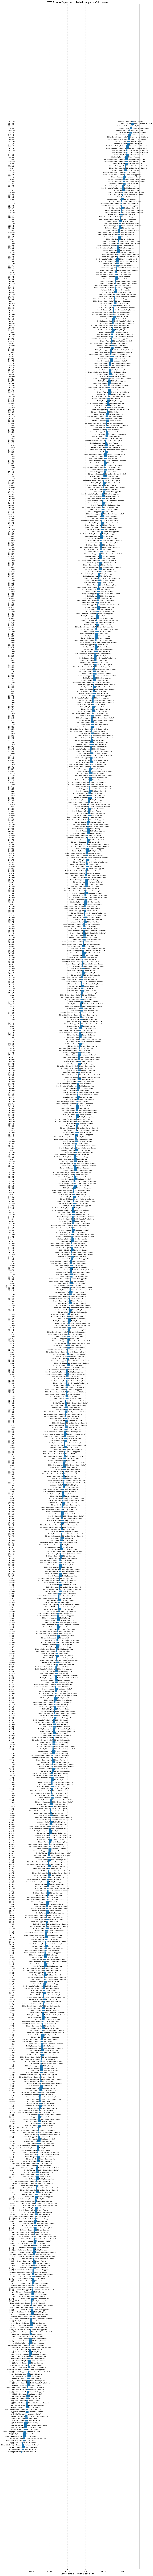

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
# 1) Parse GTFS times (supports >24h) as Timedelta
def parse_td(col):
    # pd.to_timedelta understands '25:13:00' as 1 day 1:13:00
    td = pd.to_timedelta(col, errors='coerce')
    # (Optional) if you have malformed rows, fix with a fallback:
    if td.isna().any():
        td = col.apply(lambda s: pd.to_timedelta(s) if isinstance(s, str) else pd.NaT)
    return td

df = df.copy()
df["dep_td"] = parse_td(df["departure_time"])
df["arr_td"] = parse_td(df["arrival_time"])

# 2) Convert to minutes from service-day start (numeric axis for plotting)
df["dep_min"] = df["dep_td"].dt.total_seconds() / 60.0
df["arr_min"] = df["arr_td"].dt.total_seconds() / 60.0
df["dur_min"] = df["arr_min"] - df["dep_min"]

# 3) (Optional) sort by departure time
df = df.sort_values("dep_min").reset_index(drop=True)

# 4) Build the plot
fig, ax = plt.subplots(figsize=(12, 200))

# y positions
ypos = np.arange(len(df))

for y, row in zip(ypos, df.itertuples()):
    # bar
    ax.broken_barh([(row.dep_min, row.dur_min)], (y - 0.4, 0.8))
    # labels at start/end (slight offsets to avoid overlap with the bar edge)
    ax.text(row.dep_min - 1, y, row.start_stop_name, ha="right", va="center", fontsize=8)
    ax.text(row.arr_min + 1, y, row.end_stop_name,   ha="left",  va="center", fontsize=8)

# 5) Axis formatting
def minutes_to_hhmm(x, _pos):
    # show HH:MM with HH possibly >= 24
    if np.isnan(x):
        return ""
    h = int(x // 60)
    m = int(x % 60)
    return f"{h:02d}:{m:02d}"

ax.xaxis.set_major_formatter(FuncFormatter(minutes_to_hhmm))

# y-ticks as trip labels (choose what you like: short name, headsign, or trip_id)
label_col = "trip_short_name" if "trip_short_name" in df.columns else "trip_id"
ax.set_yticks(ypos)
ax.set_yticklabels(df[label_col].astype(str))

ax.set_xlabel("Service time (HH:MM from day start)")
ax.set_ylabel("Trip")
ax.set_title("GTFS Trips — Departure to Arrival (supports >24h times)")
ax.grid(axis="x", linestyle=":", alpha=0.4)

plt.tight_layout()
plt.show()